In [92]:

import collections
import time
from itertools import chain
from sklearn.linear_model import LinearRegression


In [93]:
from utils.OutlierUtils import remove_outliers_by_region
from utils.OutlierUtils import sanitize_response_name
from utils.OutlierUtils import left_derivatives
from ConstrainedPOptimization import *

In [94]:
# This cell is tagged with 'parameters'
output_path = './output/first_attempt'
path_to_data = './data/Example_processed_data_020525_after_25000.csv'
response_index = 0
report_prefix = "Example Report"
target_regions = 4
tolerance = 0.0

In [95]:
# Import data
df = pd.read_csv(path_to_data)
t = df['Time']
t.max()
df.columns

Index(['Time', 'Pt'], dtype='object')

In [96]:
# set the response data
if not df.columns.empty:
    cols_to_drop = []
    if 'Time' in df.columns:
        cols_to_drop.append('Time')
    if 'Replicate' in df.columns:
        cols_to_drop.append('Replicate')
    if 'Reading' in df.columns:
        cols_to_drop.append('Reading')

    responses = df.drop(columns=cols_to_drop)
    if responses.empty and not df.empty: # Check if all columns were dropped, and df wasn't empty initially
        raise ValueError("All columns were identified as non-response columns. No response data left.")
else:
    raise ValueError("DataFrame has no columns.")

response = responses.columns[response_index]
response_data = df[response]

In [97]:
# creat output folder
os.makedirs(f'{output_path}', exist_ok=True)

#create dataset path
dataset_name = path_to_data.split('/')[-1].split('.')[0]
dataset_path = f'{output_path}/{dataset_name}'

os.makedirs(dataset_path, exist_ok=True)

In [98]:
safe_name = sanitize_response_name(response)
figure_dir = f'{dataset_path}/figures/{safe_name}'
os.makedirs(figure_dir, exist_ok=True)

In [99]:
# Identifying shifts with k-means
X = collections.deque(t)
Y = collections.deque(response_data)

In [100]:
# Identify dataset for clustering
# Since data is always increasing, we can remove everything after the maximum point for clustering
df_c = df.loc[:, df.columns.intersection(['Time',f'{response}'])]

df_c_response_idxMax = df_c.idxmax()[response]
df_c = df_c.iloc[:df_c_response_idxMax+1]

# Normalize data
df_c['Time'] = df_c['Time'] - df_c['Time'].min()
df_c


,Time,Pt
0,0.000,180.001134
1,0.151,130.000592
2,0.301,70.000171
3,0.452,160.000896
4,0.602,70.000171
...,...,...
4503,677.261,50689.771590
4504,677.411,55909.190650
4505,677.561,63581.175640
4506,677.712,65509.860360


In [101]:
%matplotlib qt

clicked_coordinates = None # Variable to store the click location
left_derivatives_df_c = left_derivatives(df_c['Time'].to_numpy(), df_c[response].to_numpy())


def onclick(event):
    global clicked_coordinates # Declare it global to modify the outside variable
    if event.xdata is not None and event.ydata is not None:
        clicked_coordinates = (event.xdata, event.ydata)
        print(f"Clicked at data coordinates: x={event.xdata}, y={event.ydata}")
        plt.close(fig) # Close the window

    else:
        print("Click was outside the plot area.")

fig, ax1 = plt.subplots(figsize=(18, 12), layout='constrained') # Increased figure size for clarity
plt.scatter(left_derivatives_df_c['Time'], left_derivatives_df_c['Left_Derivative'])
plt.scatter(df_c['Time'], df_c[response])

# Save derivative and data pllot
plt.savefig(f'{output_path}/{dataset_name}/Derivative-Data-Plot', bbox_inches='tight',dpi=300)

cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Now your loop can run while the plot is interactive
print("Waiting for a click...")
start_time = time.time()
timeout_seconds = 1000 # Your desired timeout

while True:
    if clicked_coordinates:
        print(f"Click detected at: {clicked_coordinates}")
        break
    if (time.time() - start_time) > timeout_seconds:
        print('Timed out. No click detected within the specified time.')
        break
    plt.pause(0.1) # Process GUI events for a short period
                   # This is crucial for interactive mode to work
plt.ioff() # Turn off interactive mode
plt.show() # Keep the plot open until manually closed after the loop

Waiting for a click...
Clicked at data coordinates: x=211.2995729380643, y=-2241.6951027749456
Click detected at: (np.float64(211.2995729380643), np.float64(-2241.6951027749456))


In [102]:
%matplotlib inline

# After the window is closed, you can access the stored coordinates
if clicked_coordinates:
    print(f"The final stored coordinates are: {clicked_coordinates}")
else:
    print("No valid click was registered before the window closed.")

first_region = (np.array([0]).astype(float)[0], clicked_coordinates[0])
first_region

The final stored coordinates are: (np.float64(211.2995729380643), np.float64(-2241.6951027749456))


(np.float64(0.0), np.float64(211.2995729380643))

In [103]:
# Get left derivatives
left_derivatieves_df_c = left_derivatives_df_c[left_derivatives_df_c['Time'] > first_region[1]]
left_derivatives_df_c.set_index(['Time'], inplace=True)
left_derivatives_df_c

,Y,Left_Derivative
Time,,
0.000,180.001134,NaN
0.151,130.000592,-331.129421
0.301,70.000171,-400.002800
0.452,160.000896,596.031288
0.602,70.000171,-600.004830
...,...,...
677.261,50689.771590,-30842.624635
677.411,55909.190650,34796.127067
677.561,63581.175640,51146.566600


In [104]:
# Define the first region
mask1 = (left_derivatives_df_c['Left_Derivative'] > left_derivatives_df_c['Y'])
shifts = left_derivatives_df_c[mask1]
mask2 = (shifts.index > first_region[1])
shifts = shifts[mask2]

shifts


,Y,Left_Derivative
Time,,
211.315,3380.399901,10935.292860
211.466,4990.871656,10665.375861
211.616,6471.465463,9870.625380
276.439,12295.288820,12743.442667
290.577,11294.463010,11608.465700
342.466,12105.126520,12658.880530
356.453,460.007406,600.017430
357.656,470.007732,1866.709787
357.807,2420.204991,12915.213638


In [105]:
def get_detected_intervals(shifts_index: list):
    result = [first_region]
    for i in range(1,len(shifts_index)-1):
        start_p = shifts_index[i]
        next_p = shifts_index[i+1]
        result.append((start_p, next_p))
    return result

detected_intervals = get_detected_intervals(shifts_index=shifts.index)
detected_intervals.append((detected_intervals[-1][1], df_c['Time'].max()))
detected_intervals


[(np.float64(0.0), np.float64(211.2995729380643)),
 (np.float64(211.46600000000035), np.float64(211.6160000000018)),
 (np.float64(211.6160000000018), np.float64(276.4390000000021)),
 (np.float64(276.4390000000021), np.float64(290.57700000000114)),
 (np.float64(290.57700000000114), np.float64(342.46600000000035)),
 (np.float64(342.46600000000035), np.float64(356.45300000000134)),
 (np.float64(356.45300000000134), np.float64(357.65599999999904)),
 (np.float64(357.65599999999904), np.float64(357.8070000000007)),
 (np.float64(357.8070000000007), np.float64(357.95700000000215)),
 (np.float64(357.95700000000215), np.float64(358.10699999999997)),
 (np.float64(358.10699999999997), np.float64(358.25800000000163)),
 (np.float64(358.25800000000163), np.float64(358.40799999999945)),
 (np.float64(358.40799999999945), np.float64(359.01000000000204)),
 (np.float64(359.01000000000204), np.float64(521.8950000000004)),
 (np.float64(521.8950000000004), np.float64(522.1959999999999)),
 (np.float64(522.195

In [106]:
merged_points = merge_close_points(df=df_c, regions=detected_intervals, p=75, response=response)
merged_points_list = sorted(list(set(tuple(chain.from_iterable(merged_points)))))
merged_points

INFO:          Time           Pt
0       0.000   180.001134
1       0.151   130.000592
2       0.301    70.000171
3       0.452   160.000896
4       0.602    70.000171
...       ...          ...
1400  210.563    60.000126
1401  210.714    50.000087
1402  210.864    80.000224
1403  211.014   530.009832
1404  211.165  1740.105972

[1405 rows x 2 columns]
INFO: Starting merge: curr_region=(np.float64(0.0), np.float64(211.2995729380643)), curr_median=110.00
INFO: Comparing curr_region=(np.float64(0.0), np.float64(211.2995729380643)) (median=110.00) with next_region=(np.float64(211.46600000000035), np.float64(211.6160000000018)) (median=5731.17)
INFO:   -> Not mergeable. Appending (np.float64(0.0), np.float64(211.2995729380643)). New curr_region=(np.float64(211.46600000000035), np.float64(211.6160000000018))
INFO: Comparing curr_region=(np.float64(211.46600000000035), np.float64(211.6160000000018)) (median=5731.17) with next_region=(np.float64(211.6160000000018), np.float64(276.439000000002

(np.float64(0.0), np.float64(211.2995729380643))
get_region called with t0=0.0, tf=211.2995729380643. Filtered DataFrame shape: (1405, 2)
get_region called with t0=211.46600000000035, tf=211.6160000000018. Filtered DataFrame shape: (2, 2)
get_region called with t0=211.6160000000018, tf=276.4390000000021. Filtered DataFrame shape: (432, 2)
get_region called with t0=276.4390000000021, tf=290.57700000000114. Filtered DataFrame shape: (95, 2)
get_region called with t0=290.57700000000114, tf=342.46600000000035. Filtered DataFrame shape: (346, 2)
get_region called with t0=342.46600000000035, tf=356.45300000000134. Filtered DataFrame shape: (94, 2)
get_region called with t0=356.45300000000134, tf=357.65599999999904. Filtered DataFrame shape: (9, 2)
get_region called with t0=357.65599999999904, tf=357.8070000000007. Filtered DataFrame shape: (2, 2)
get_region called with t0=357.8070000000007, tf=357.95700000000215. Filtered DataFrame shape: (2, 2)
get_region called with t0=357.95700000000215, 

[(np.float64(0.0), np.float64(211.2995729380643)),
 (np.float64(211.46600000000035), np.float64(211.6160000000018)),
 (np.float64(211.6160000000018), np.float64(276.4390000000021)),
 (np.float64(356.45300000000134), np.float64(357.65599999999904)),
 (np.float64(357.65599999999904), np.float64(357.8070000000007)),
 (np.float64(357.8070000000007), np.float64(357.95700000000215)),
 (np.float64(357.95700000000215), np.float64(358.10699999999997)),
 (np.float64(358.25800000000163), np.float64(358.40799999999945)),
 (np.float64(521.8950000000004), np.float64(522.1959999999999)),
 (np.float64(522.1959999999999), np.float64(522.4969999999994)),
 (np.float64(522.9480000000003), np.float64(523.0980000000018)),
 (np.float64(523.0980000000018), np.float64(523.2489999999998)),
 (np.float64(523.2489999999998), np.float64(523.3990000000013)),
 (np.float64(523.5499999999993), np.float64(523.8500000000022))]

In [107]:
shifts

,Y,Left_Derivative
Time,,
211.315,3380.399901,10935.292860
211.466,4990.871656,10665.375861
211.616,6471.465463,9870.625380
276.439,12295.288820,12743.442667
290.577,11294.463010,11608.465700
342.466,12105.126520,12658.880530
356.453,460.007406,600.017430
357.656,470.007732,1866.709787
357.807,2420.204991,12915.213638


## Final Plot

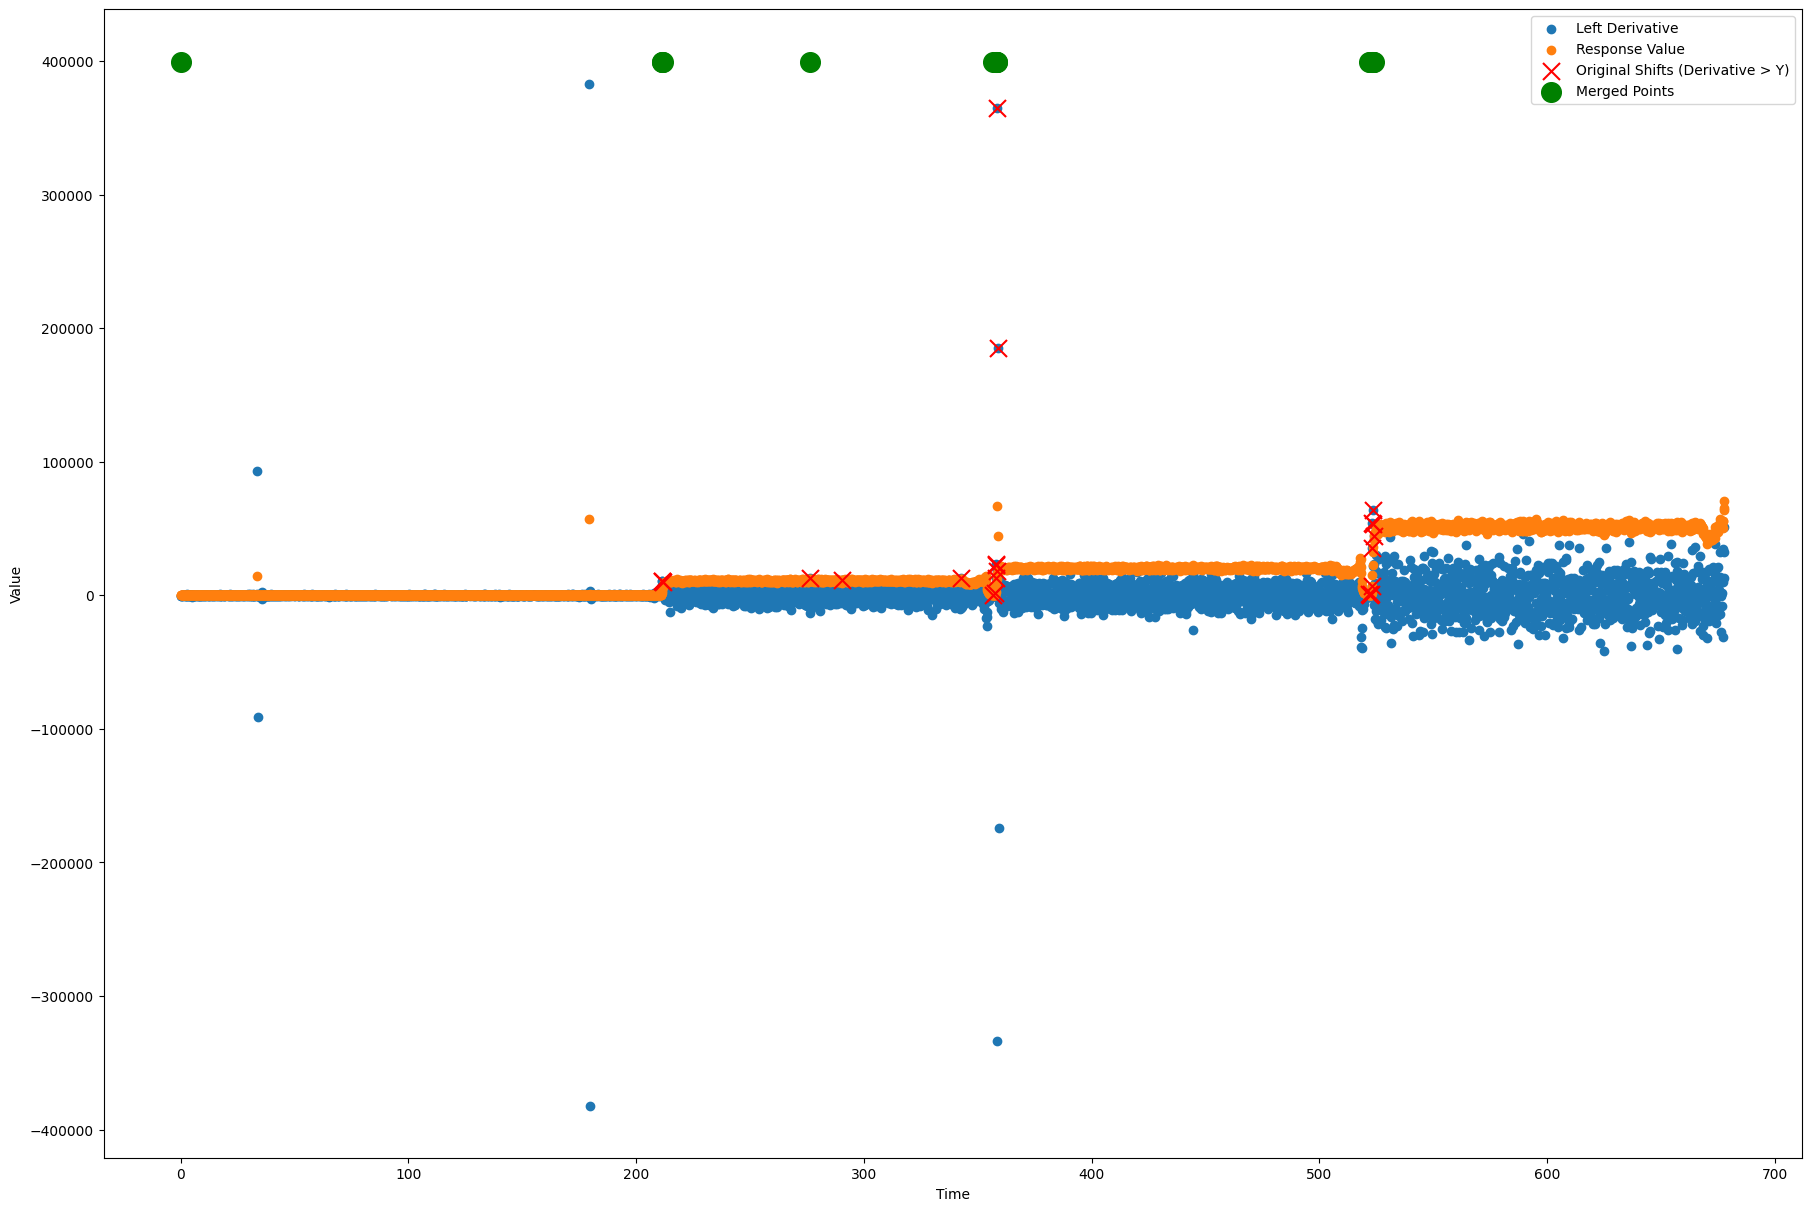

In [108]:
fig, ax1 = plt.subplots(figsize=(18, 12), layout='constrained')

# Plot original data and derivatives
ax1.scatter(left_derivatives_df_c.index, left_derivatives_df_c['Left_Derivative'], label='Left Derivative')
ax1.scatter(df_c['Time'], df_c[response], label='Response Value')

# Plot the original 'shifts' as red 'x' marks
ax1.scatter(shifts.index,
            left_derivatives_df_c.loc[shifts.index, 'Left_Derivative'],
            marker='x', color='red', s=150, zorder=4, label='Original Shifts (Derivative > Y)')


# Add the merged points to the plot as green circles
ax1.scatter(merged_points_list, [ax1.get_ylim()[1] * 0.95] * len(merged_points_list),
            marker='o', color='green', s=200, zorder=5, label='Merged Points') # Plot high up to be visible'

ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.legend()
plt.savefig(f'{figure_dir}/Regional-Final.png',bbox_inches='tight',dpi=300)
plt.show()


In [109]:
detected_intervals = get_detected_intervals(shifts_index=merged_points_list)
detected_intervals.append((detected_intervals[-1][1], df_c['Time'].max()))
detected_intervals
# detected_intervals

[(np.float64(0.0), np.float64(211.2995729380643)),
 (np.float64(211.2995729380643), np.float64(211.46600000000035)),
 (np.float64(211.46600000000035), np.float64(211.6160000000018)),
 (np.float64(211.6160000000018), np.float64(276.4390000000021)),
 (np.float64(276.4390000000021), np.float64(356.45300000000134)),
 (np.float64(356.45300000000134), np.float64(357.65599999999904)),
 (np.float64(357.65599999999904), np.float64(357.8070000000007)),
 (np.float64(357.8070000000007), np.float64(357.95700000000215)),
 (np.float64(357.95700000000215), np.float64(358.10699999999997)),
 (np.float64(358.10699999999997), np.float64(358.25800000000163)),
 (np.float64(358.25800000000163), np.float64(358.40799999999945)),
 (np.float64(358.40799999999945), np.float64(521.8950000000004)),
 (np.float64(521.8950000000004), np.float64(522.1959999999999)),
 (np.float64(522.1959999999999), np.float64(522.4969999999994)),
 (np.float64(522.4969999999994), np.float64(522.9480000000003)),
 (np.float64(522.94800000

get_region called with t0=0.0, tf=211.2995729380643. Filtered DataFrame shape: (1405, 2)
get_region called with t0=15.0, tf=196.2995729380643. Filtered DataFrame shape: (1206, 2)
get_region called with t0=211.2995729380643, tf=211.46600000000035. Filtered DataFrame shape: (2, 2)
get_region called with t0=226.2995729380643, tf=196.46600000000035. Filtered DataFrame shape: (0, 2)


get_region called with t0=211.46600000000035, tf=211.6160000000018. Filtered DataFrame shape: (2, 2)
get_region called with t0=226.46600000000035, tf=196.6160000000018. Filtered DataFrame shape: (0, 2)
get_region called with t0=211.6160000000018, tf=276.4390000000021. Filtered DataFrame shape: (432, 2)
get_region called with t0=226.6160000000018, tf=261.4390000000021. Filtered DataFrame shape: (232, 2)
get_region called with t0=276.4390000000021, tf=356.45300000000134. Filtered DataFrame shape: (533, 2)
get_region called with t0=291.4390000000021, tf=341.45300000000134. Filtered DataFrame shape: (333, 2)
get_region called with t0=356.45300000000134, tf=357.65599999999904. Filtered DataFrame shape: (9, 2)
get_region called with t0=371.45300000000134, tf=342.65599999999904. Filtered DataFrame shape: (0, 2)


get_region called with t0=357.65599999999904, tf=357.8070000000007. Filtered DataFrame shape: (2, 2)
get_region called with t0=372.65599999999904, tf=342.8070000000007. Filtered DataFrame shape: (0, 2)
get_region called with t0=357.8070000000007, tf=357.95700000000215. Filtered DataFrame shape: (2, 2)
get_region called with t0=372.8070000000007, tf=342.95700000000215. Filtered DataFrame shape: (0, 2)
get_region called with t0=357.95700000000215, tf=358.10699999999997. Filtered DataFrame shape: (2, 2)
get_region called with t0=372.95700000000215, tf=343.10699999999997. Filtered DataFrame shape: (0, 2)
get_region called with t0=358.10699999999997, tf=358.25800000000163. Filtered DataFrame shape: (2, 2)
get_region called with t0=373.10699999999997, tf=343.25800000000163. Filtered DataFrame shape: (0, 2)


get_region called with t0=358.25800000000163, tf=358.40799999999945. Filtered DataFrame shape: (2, 2)
get_region called with t0=373.25800000000163, tf=343.40799999999945. Filtered DataFrame shape: (0, 2)


get_region called with t0=358.40799999999945, tf=521.8950000000004. Filtered DataFrame shape: (1088, 2)
get_region called with t0=373.40799999999945, tf=506.89500000000044. Filtered DataFrame shape: (888, 2)
get_region called with t0=521.8950000000004, tf=522.1959999999999. Filtered DataFrame shape: (3, 2)
get_region called with t0=536.8950000000004, tf=507.1959999999999. Filtered DataFrame shape: (0, 2)
get_region called with t0=522.1959999999999, tf=522.4969999999994. Filtered DataFrame shape: (3, 2)
get_region called with t0=537.1959999999999, tf=507.4969999999994. Filtered DataFrame shape: (0, 2)
get_region called with t0=522.4969999999994, tf=522.9480000000003. Filtered DataFrame shape: (4, 2)
get_region called with t0=537.4969999999994, tf=507.9480000000003. Filtered DataFrame shape: (0, 2)


get_region called with t0=522.9480000000003, tf=523.0980000000018. Filtered DataFrame shape: (2, 2)
get_region called with t0=537.9480000000003, tf=508.0980000000018. Filtered DataFrame shape: (0, 2)
get_region called with t0=523.0980000000018, tf=523.2489999999998. Filtered DataFrame shape: (2, 2)
get_region called with t0=538.0980000000018, tf=508.2489999999998. Filtered DataFrame shape: (0, 2)
get_region called with t0=523.2489999999998, tf=523.3990000000013. Filtered DataFrame shape: (2, 2)
get_region called with t0=538.2489999999998, tf=508.39900000000125. Filtered DataFrame shape: (0, 2)
get_region called with t0=523.3990000000013, tf=523.5499999999993. Filtered DataFrame shape: (2, 2)
get_region called with t0=538.3990000000013, tf=508.5499999999993. Filtered DataFrame shape: (0, 2)
get_region called with t0=523.5499999999993, tf=523.8500000000022. Filtered DataFrame shape: (3, 2)
get_region called with t0=538.5499999999993, tf=508.8500000000022. Filtered DataFrame shape: (0, 2)

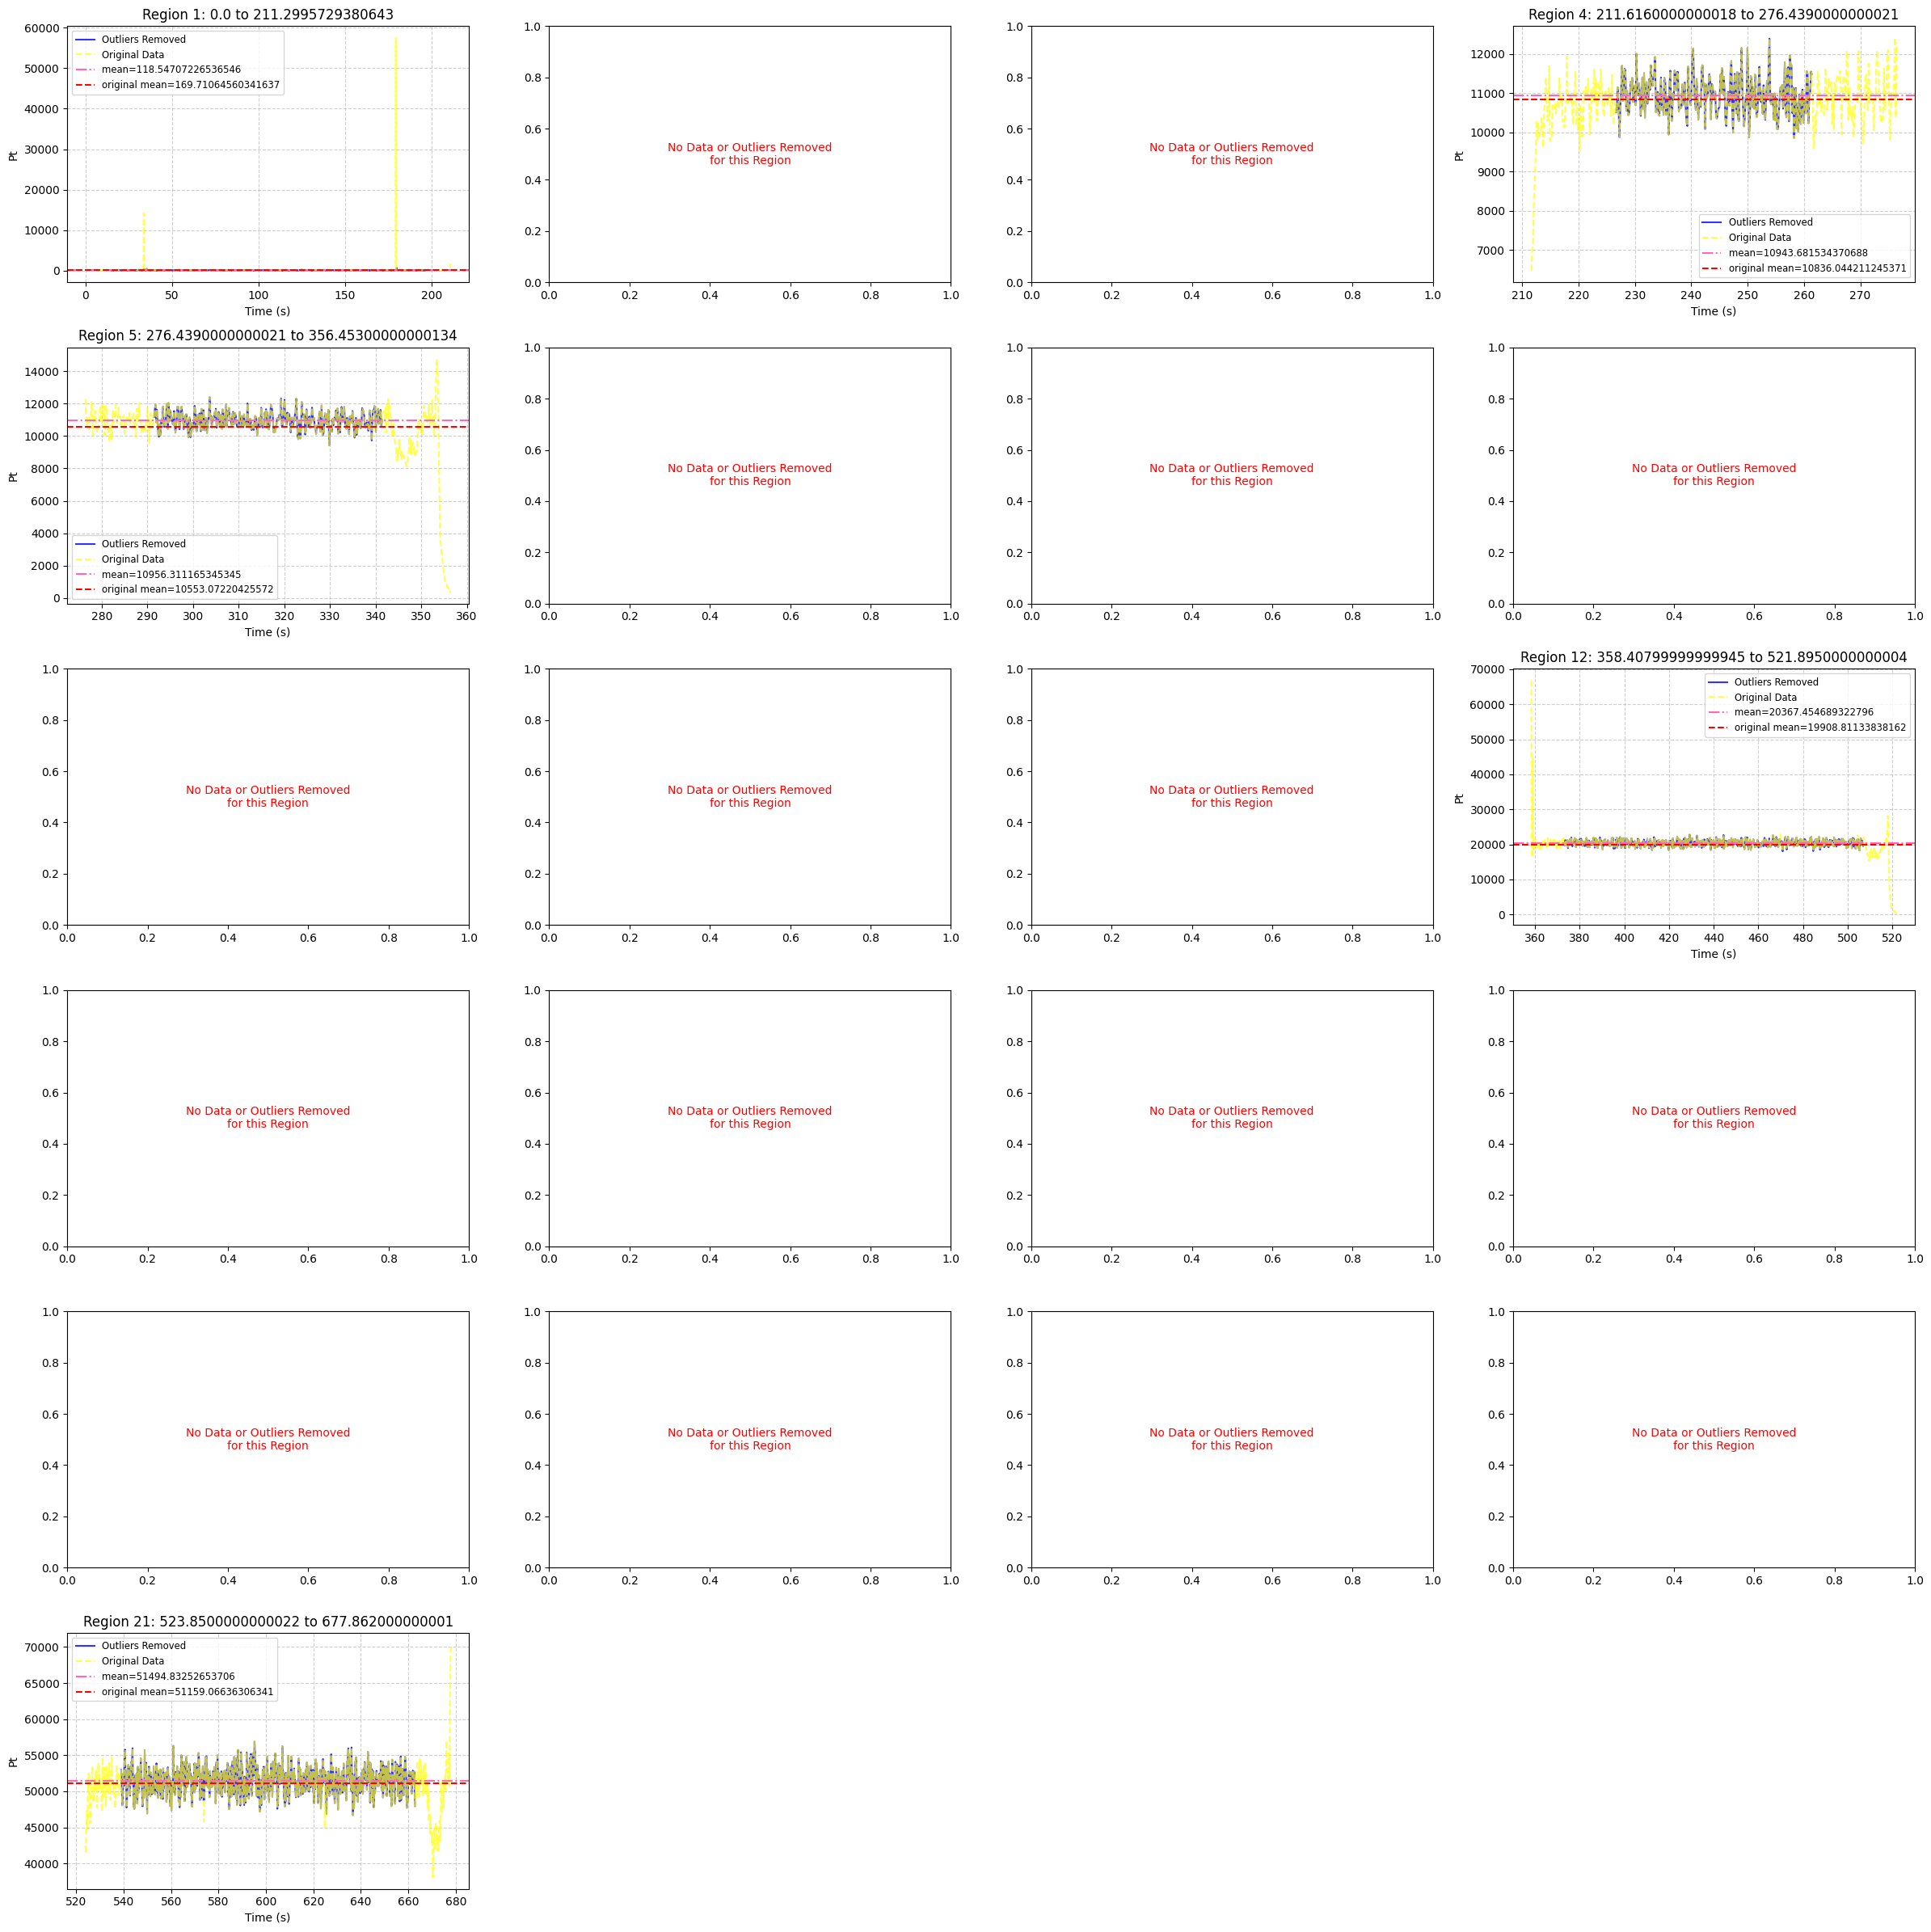

In [110]:
regional_means = []

num_regions = len(detected_intervals)
ncols = 4 # You can change the number of columns
nrows = (num_regions + ncols - 1) // ncols

offset = 15 # 15 seconds offset to 

final_df = pd.DataFrame()


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 4 * nrows))
axes_flat = axes.flatten() # Flatten the 2D axes array for easier iteration
for i, (x0, x1) in enumerate(detected_intervals):
    # Get the current Axes object for this iteration from the flattened array
    if i < len(axes_flat):
        current_ax = axes_flat[i]
    else:
        # This case should ideally not happen if nrows is calculated correctly,
        # but provides a safeguard if more plots are attempted than subplots available.
        logging.warning(f" Not enough subplots for region {i+1}. Skipping plot.")
        continue
    

    # Call your outlier removal function for the current region
    original_region_data = get_region(df=df_c, t0=x0, tf=x1)
    Y_prime = remove_outliers_by_region(R=(x0 + offset, x1 - offset), response_column_name=response, Y=df_c)

    # print(f'New Region {i+1}: ({val['Start'] + offset}, {val['End'] - offset})')

    # Plot the results on the current subplot
    if not Y_prime.empty:
        # Plot the data after outlier removal
        current_ax.plot(Y_prime['Time'], Y_prime[response], label='Outliers Removed', color='blue', alpha=0.8)
        
        # Plot original data for comparison (only within the current region)

        
        current_ax.plot(original_region_data['Time'], original_region_data[response],
                        '--', color='yellow', alpha=0.7, label='Original Data')
        
        region_mean = Y_prime[response].mean()
        original_mean = original_region_data[response].mean()
        
        current_ax.axhline(y=region_mean, color='#FF69B4', linestyle='-.', label=f'mean={region_mean}')
        current_ax.axhline(y=original_mean, color='red', linestyle='--', label=f'original mean={original_mean}')

        regional_means.append(region_mean)
        
        current_ax.legend(fontsize='small')
    else:
        current_ax.text(0.5, 0.5, 'No Data or Outliers Removed\nfor this Region',
                        horizontalalignment='center', verticalalignment='center',
                        transform=current_ax.transAxes, fontsize=10, color='red')
        continue

    # Set titles and labels for the current subplot
    current_ax.set_title(f'Region {i+1}: {x0} to {x1}')
    current_ax.set_xlabel('Time (s)')
    current_ax.set_ylabel(f'{response}')
    current_ax.grid(True, linestyle='--', alpha=0.6) # Add a grid for better readability

    final_df = pd.concat([final_df, Y_prime], ignore_index=True)



# This prevents empty plots from appearing if your `area_df` has fewer regions than the grid size
for j in range(num_regions, len(axes_flat)):
    fig.delaxes(axes_flat[j])

plt.savefig(f'{figure_dir}/regions.png',
             bbox_inches='tight',
             dpi=300)
plt.tight_layout() # Automatically adjust subplot parameters for a tight layout
plt.show() # Display the plot
    
# plt.tight_layout()
# plt.show()

In [111]:
final_df = final_df.sort_index()
final_df

,Time,Pt
0,15.041,50.000087
1,15.191,70.000171
2,15.341,110.000423
3,15.492,100.000350
4,15.642,100.000350
...,...,...
3473,662.220,51030.983140
3474,662.371,52345.727250
3475,662.521,52747.199900
3476,662.672,50448.921270


[np.float64(118.54707226536546),
 np.float64(10943.681534370688),
 np.float64(10956.311165345345),
 np.float64(20367.454689322796),
 np.float64(51494.83252653706)]

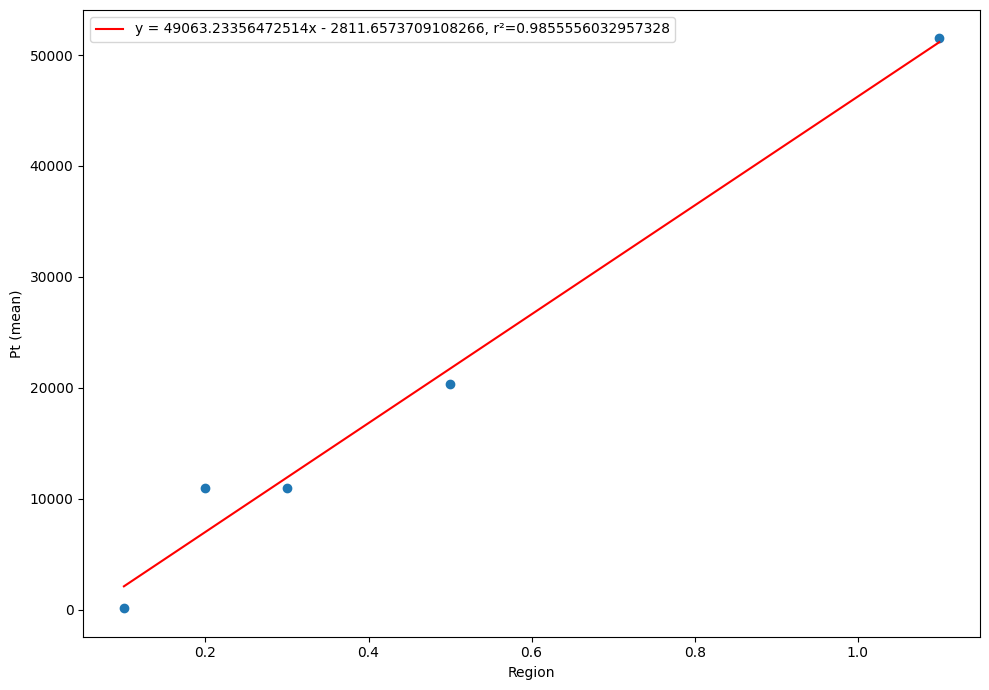

In [117]:
display(regional_means)
# Plot regional means
labels = np.array([1,2,3,5,11])/10
data = pd.DataFrame(regional_means, labels)

fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot the bars
ax1.scatter(data.index, data.values)  # Convert index to string for proper label display
m,b = np.polyfit(labels, regional_means, 1)

model = LinearRegression()

X = labels.reshape(-1, 1)
y = np.array(regional_means)

model.fit(X,y)

r_squared = model.score(X,y)


# Find regression equation
if b >= 0:
    line_label = f'y = {m}x + {b}'
else:
    line_label = f'y = {m}x - {-b}' # Use -b to show a positive number after the minus sign

ax1.plot(labels, m*labels + b, color='red', label=f'{line_label}, r²={r_squared}')


plt.legend()

ax1.set_xlabel('Region')
ax1.set_ylabel(f'{response} (mean)')



plt.tight_layout()
plt.savefig(f'{figure_dir}/Regression-Plot.png', bbox_inches='tight',dpi=300)
plt.show()


$$ \textit{Opus ex amino, } \\ \text{Bhagawat Chapagain} $$